In [1]:
#import napari
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from skimage import io
import glob
from skimage.filters import threshold_local
from skimage.filters import threshold_li
from skimage.color import rgb2gray
from math import sqrt
from skimage.morphology import disk, ball
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.filters.rank import enhance_contrast
from skimage.exposure import adjust_gamma
import pickle as pkl
import sys
from datetime import date
import os, psutil
import re
process = psutil.Process(os.getpid())
# Grab utilities from the imaging directories dir
utilsDir = re.sub(r'Registration', 'Imaging Utilities', str(sys.path[0]))
# Homebrew utilities for importing ims files & basic image manipulation
sys.path.append(utilsDir)
from functools import reduce
from scipy.spatial.distance import cdist, pdist
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries

# Use this function for local thresholding of images
def lthresh(imgstk):
    th = threshold_local(imgstk, 65, offset=0)
    imgstk = imgstk>= th
    return imgstk
# Use this function to threshold images
def thresh(imgstk):
    th = threshold_li(imgstk)
    imgstk = imgstk>= th
    return imgstk
def spotcall(img, min_sig, max_sig, nsig, th):
    blobs_log = blob_log(img, min_sigma=min_sig, max_sigma=max_sig, num_sigma=nsig, threshold=th)
    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    color = 'lime'
    title = 'Laplacian of Gaussian'
    return blobs_log

In [2]:
config = {
        "data_url" : "20230530_OE19_A2",
    }
print(config)

{'data_url': '20230530_OE19_A2'}


In [3]:
runName = config['data_url']
opdir = '/mnt/disks/external/jg4159/20230530_OE19_Xenograft/' # Path to output
ip = opdir + "RegisteredImages_" + runName + ".pkl"
#mk = opdir + "Unfiltered_segmentation_" + runName +"_NO_max_img.pickle"
print(ip)
#print(mk)
print(runName)

/mnt/disks/external/jg4159/20230530_OE19_Xenograft/RegisteredImages_20230530_OE19_A2.pkl
20230530_OE19_A2


In [4]:
### VARIABLE DEFINITION ###

maxpro = True # Set false if 3D registration required
interactive = False #If true will show napari visualizations
runOnServer = True
filehandler = open(ip, 'rb')
img_stack = pkl.load(filehandler)
filehandler.close()

# Rescale image and set manual threshold 

In [5]:
from skimage.filters import threshold_local
from skimage.filters import threshold_li, threshold_yen, threshold_otsu
from skimage.color import rgb2gray

for img in img_stack[1:]:
    for i in range(img.shape[0]):
        img[i] *= 65535
        img[i] = img[i].astype(np.uint16)
        m = np.median(img[i][img[i] > 0])
        print(np.percentile(img[i], (97.5, 99.8)))

[143. 285.]
[120. 201.]
[123. 142.]
[373. 609.]
[124. 234.]
[129. 218.]
[122. 145.]
[360. 579.]
[123. 217.]
[112. 138.]
[122. 145.]
[485. 787.]
[116. 182.]
[128. 235.]
[121. 166.]
[ 599. 1009.]
[122. 231.]
[118. 180.]
[121. 145.]
[ 622. 1023.]
[127. 252.]
[121. 205.]
[124. 159.]
[555. 904.]
[117. 167.]
[114. 144.]
[130. 158.]
[458. 745.]


In [6]:
len(img_stack)

8

In [7]:
img_stack[1].shape

(4, 3789, 3789)

<Figure size 2160x1080 with 0 Axes>

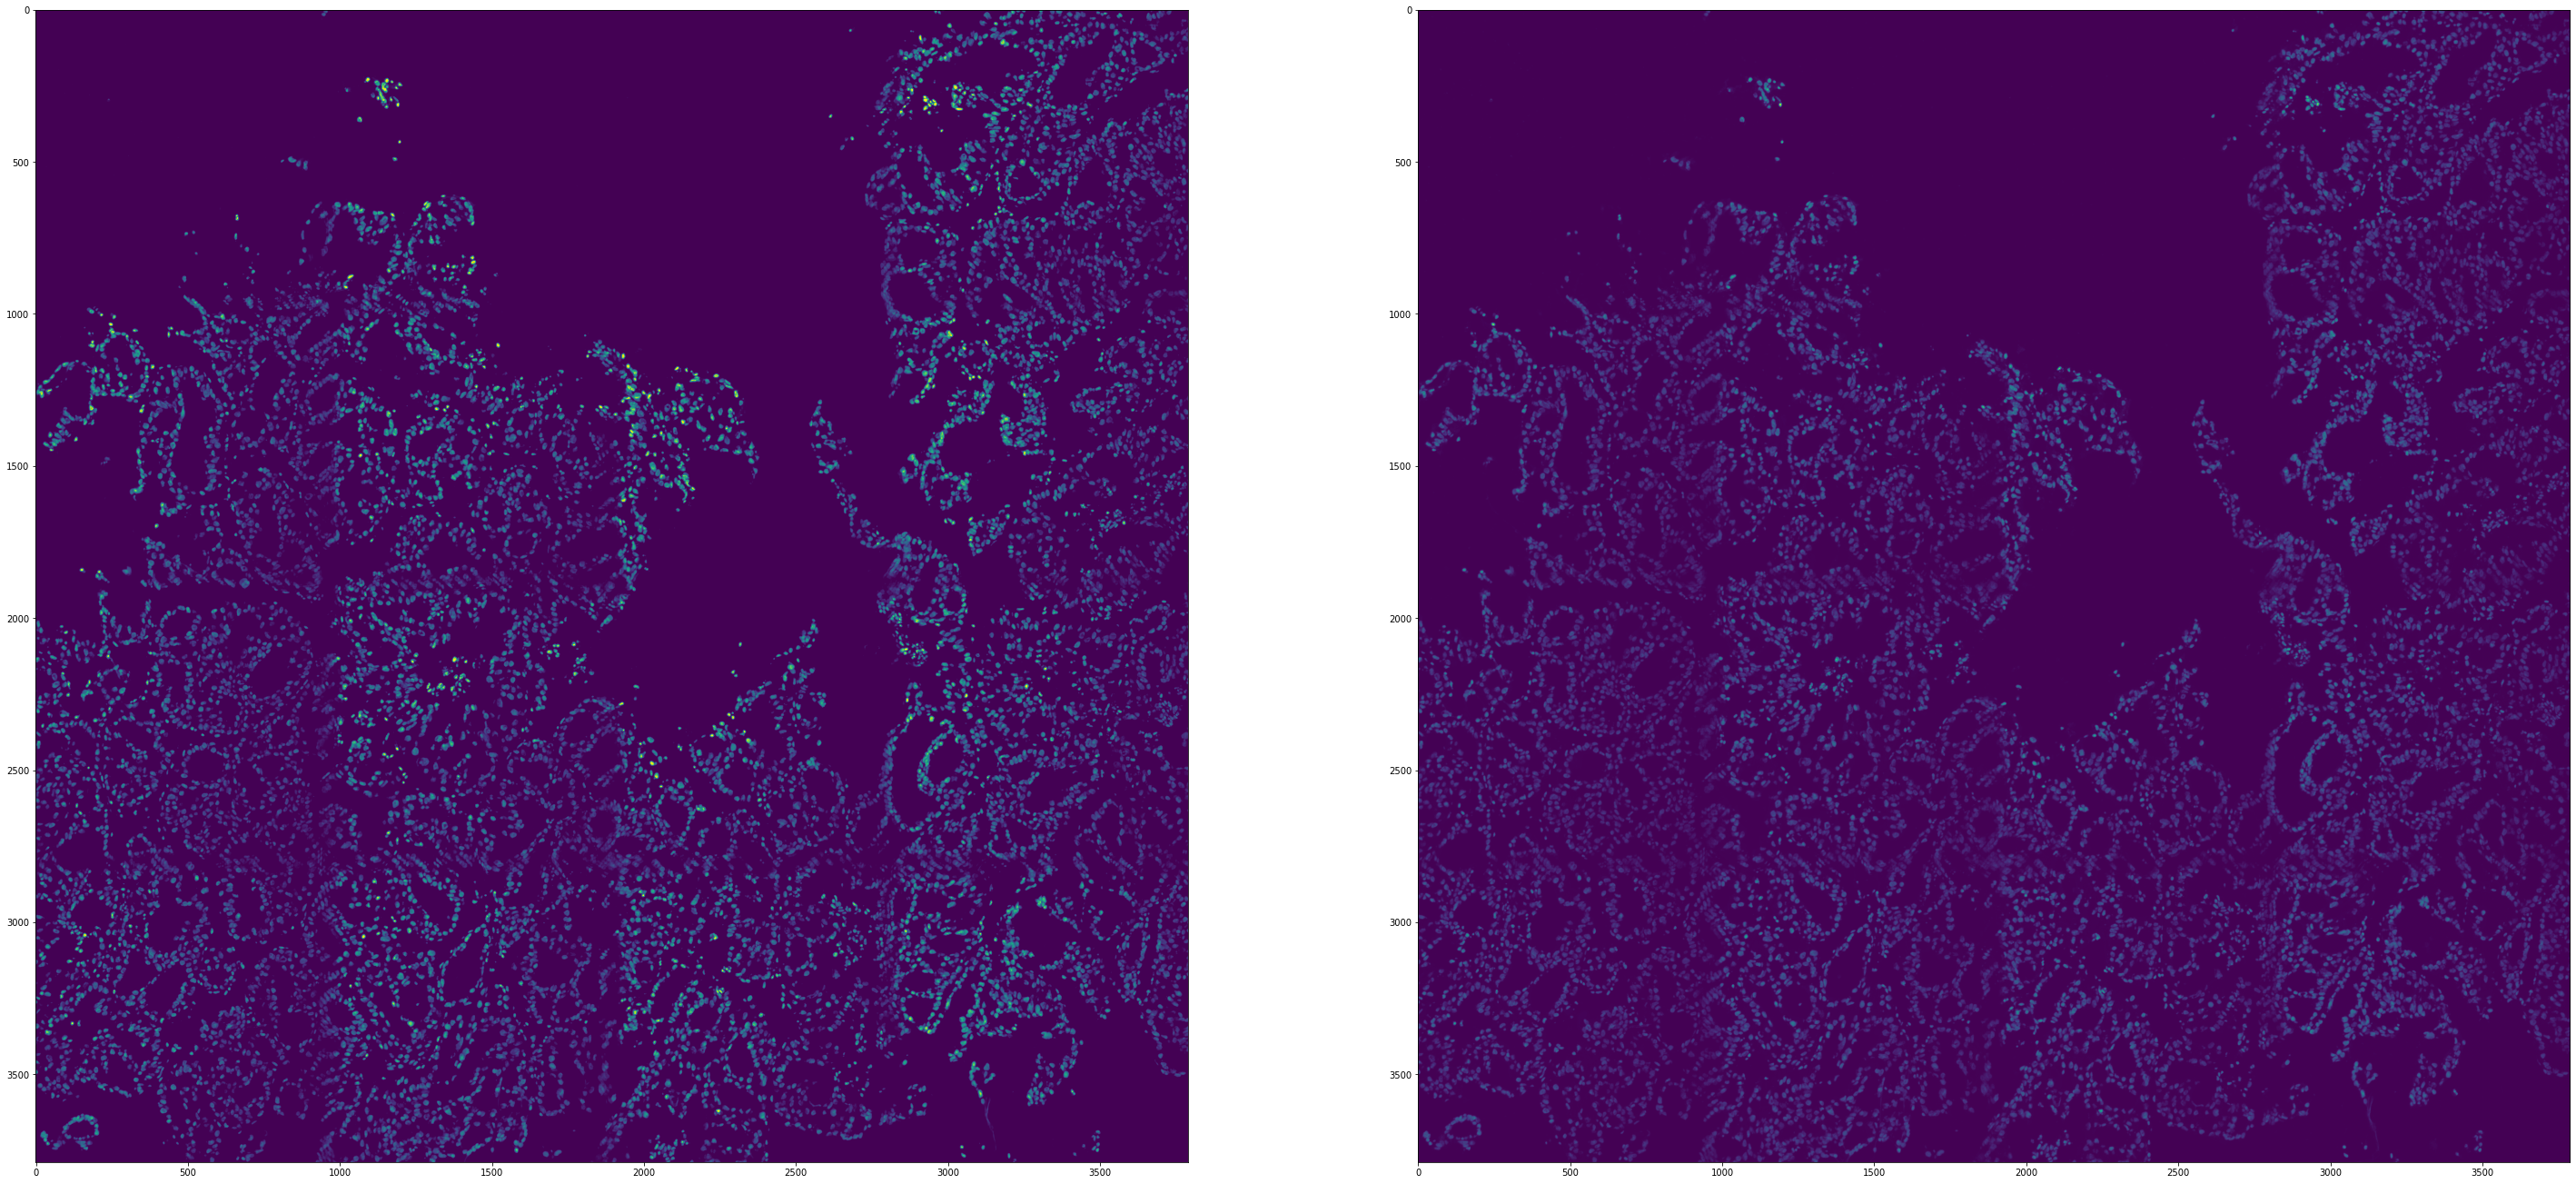

In [8]:
#Sanity check to see images thresholded correctly
plt.figure(figsize=(30, 15))
plt.rcParams['figure.figsize'] = [50, 30]
f, axarr = plt.subplots(1,2)
axarr[0].imshow(rescale_intensity(img_stack[0][3], (130,1000), (0, 255)))
axarr[1].imshow(img_stack[0][3])

In [16]:
num_chn = 3
num_cyc = 8

gamstack=[]
for i in range(num_cyc):
    if i == 7:
        for j in range(num_chn):
            if (j==0): #640
                gamstack.append(rescale_intensity(img_stack[i][j], (120,135), (0, 255)))
            elif (j==1): #561
                gamstack.append(rescale_intensity(img_stack[i][j], (120,135), (0, 255)))
            else: #488
                gamstack.append(rescale_intensity(img_stack[i][j],(130,145), (0, 255)))
    else:
        for j in range(num_chn):
            if (j==0): #640
                gamstack.append(rescale_intensity(img_stack[i][j], (125,140), (0, 255)))
            elif (j==1): #561
                gamstack.append(rescale_intensity(img_stack[i][j], (125,140), (0, 255)))
            else: #488
                gamstack.append(rescale_intensity(img_stack[i][j],(130,145), (0, 255)))
   
   

In [15]:
filehandler = open(opdir+ 'A2-nuc'+ '.pickle', 'wb')
pkl.dump((rescale_intensity(img_stack[0][3], (130,1000), (0, 255))), filehandler)
filehandler.close()

In [17]:
import time
start_time = time.time()

all_spots = np.zeros(shape=(0,3))
spotlist = []
cyc=0
for img in gamstack:
    print("Cycle " + str(cyc//3+1)+ ", channel" + str(cyc%3) + ":")
    spots = spotcall(img[:,:],min_sig=0.5,max_sig=1,nsig=5,th=0.5) # Decrease threshold if spots are not identified and min sigma if spots are smaller
    spotlist.append(spots)
    all_spots = np.concatenate((all_spots, spots), axis=0)
    print("Spots called: "+str(len(spots)))
    cyc=cyc+1
        
total_spots = all_spots.shape[0]
print("Total # of spots:", total_spots)
all_spots = np.unique(all_spots, axis=0)
total_spots = all_spots.shape[0]
print("Total # of unique spots:", total_spots)
print("--- %s seconds ---" % (time.time() - start_time))

Cycle 1, channel0:
Spots called: 74258
Cycle 1, channel1:
Spots called: 44077
Cycle 1, channel2:
Spots called: 41274
Cycle 2, channel0:
Spots called: 98989
Cycle 2, channel1:
Spots called: 44024
Cycle 2, channel2:
Spots called: 21928
Cycle 3, channel0:
Spots called: 64750
Cycle 3, channel1:
Spots called: 65934
Cycle 3, channel2:
Spots called: 24026
Cycle 4, channel0:
Spots called: 56409
Cycle 4, channel1:
Spots called: 11312
Cycle 4, channel2:
Spots called: 19643
Cycle 5, channel0:
Spots called: 30173
Cycle 5, channel1:
Spots called: 64289
Cycle 5, channel2:
Spots called: 25577
Cycle 6, channel0:
Spots called: 51463
Cycle 6, channel1:
Spots called: 38860
Cycle 6, channel2:
Spots called: 17861
Cycle 7, channel0:
Spots called: 66503
Cycle 7, channel1:
Spots called: 45430
Cycle 7, channel2:
Spots called: 31328
Cycle 8, channel0:
Spots called: 42937
Cycle 8, channel1:
Spots called: 27266
Cycle 8, channel2:
Spots called: 58576
Total # of spots: 1066887
Total # of unique spots: 848816
--- 54

In [11]:
import pandas as pd
codebook = '/mnt/disks/external/jg4159/BEpilot/DDR364_codebook.csv'
cb = pd.read_csv(codebook, sep=',', header=0, index_col='Gene')

cb_list = np.asarray(cb.values.tolist(),dtype=bool)
genes = cb.index.tolist()
print(np.asarray(cb_list[0]).shape)

(24,)


In [12]:
xmax = gamstack[0].shape[0]
ymax = gamstack[0].shape[1]
#del gamstack

In [18]:
spotset=[]
for j in spotlist:
    spotset.append(set([tuple(x) for x in j[:,:2]]))

In [19]:
num_chn=3
num_cyc=8
num_pxl_list=[3]#0,0.5,1,1.5,2,2.5,3,3.5,4
guide_spots_list=[]

for num_pxl in num_pxl_list:    
    print(num_pxl)
    import time
    start_time = time.time()

    ## Guide detection, generating the bitcode by searching the spot pixel in all cycles within a given radius
    cycles = np.zeros((all_spots.shape[0],num_chn*num_cyc),dtype=bool)
    for i in range(all_spots.shape[0]): #all_spots.shape[0]
        if i%100000==0:
            print(i)
        k = 0
        # create a potential set
        spot_i = np.reshape(all_spots[i,:2],[1,2])[0]
        #print(spot_i)
        grid = []
        for dx in range(3):
            for dy in range(3):
                coord1 = tuple([np.max([0,spot_i[0]-dx]).astype(int), np.max([0,spot_i[1]-dy]).astype(int)])
                #print(coord1)
                grid.append(coord1)
                coord2 = tuple([np.min([xmax, spot_i[0]+dx]).astype(int), np.min([ymax, spot_i[1]+dy]).astype(int)])
                #print(coord2)
                grid.append(coord2)
                coord3 = tuple([np.max([0, spot_i[0]-dx]).astype(int), np.min([ymax, spot_i[1]+dy]).astype(int)])
                grid.append(coord3)
                coord4 = tuple([np.min([xmax, spot_i[0]+dx]).astype(int), np.max([0, spot_i[1]-dy]).astype(int)])
                grid.append(coord4)
        grid = set(grid)
        #print(grid)
        #break
        
        for j in spotset: 
            # give the radius is three, we can pre-set a coordinate set
            # find spots that fall within the grid, calculate distance if any
            spcell = np.array([[x[0],x[1]] for x in grid & j])
            if len(spcell>0):
                #print(spcell)
                a = cdist(np.reshape(all_spots[i,:2],[1,2]), spcell, metric='euclidean')
                #print(a)
                if np.min(a) < num_pxl: # less than num_pxl pixels 
                    cycles[i,k]=1
            k = k+1
        #print(cycles[i,:])
    print("--- %s seconds ---" % (time.time() - start_time))

# de-duplicaton
    start_time = time.time()
    spotdict = {}
    guide_spots=0
    print(len(cb_list))
    for j in range(len(cb_list)):
        print(j)
        k = 0
        abc = []
        dedup = []
        for i in range(0, cycles.shape[0]):
            if np.array_equal(cycles[i,:], np.asarray(cb_list[j])):
                k=k+1
                abc.append(all_spots[i])
        spotcycle = np.asarray(abc)
        for sp in range(spotcycle.shape[0]):
            a = cdist(np.reshape(spotcycle[sp,:2],[1,2]), spotcycle[:,:2], metric='euclidean')#distance
            if len(np.where(a<2)[1]) > 1:
                dedup.append(spotcycle[np.where(a<2)[1][0],:])
            else:
                dedup.append(spotcycle[sp,:])
        #print(dedup)
        #print(np.unique(np.asarray(dedup),axis=0).shape)
        spotdict[genes[j]] = np.unique(np.asarray(dedup),axis=0)
        guide_spots = guide_spots + len(dedup)
        #print("gene: "+genes[j]+'\tcount: '+str(len(dedup)))
    print("Total guide spots: ", guide_spots)
    #file2.write(f"Total guide spots: {guide_spots}\n")
    print("Guide spots/Total spots:", guide_spots, '/', total_spots, '=', guide_spots/total_spots)
    #file2.write(f"Guide spots/Total spots: {guide_spots} / {total_spots} = {guide_spots/total_spots}\n")
    guide_spots_list.append(guide_spots)
    print("--- %s seconds ---" % (time.time() - start_time))
    #file2.write(f"--- %s seconds --- {time.time() - start_time}\n")
    # Save max projection images for next step in pipeline
    filehandler = open(opdir+'Spots-with-dist-OPT_numpxl='+str(num_pxl)+"_"+str(guide_spots)+"_" + runName + '.pkl', 'wb')
    pkl.dump(spotdict, filehandler)
    filehandler.close()

3
0
100000
200000
300000
400000
500000
600000
700000
800000
--- 618.3610792160034 seconds ---
364
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
